<h2><center> <font color='black'> Graph Embeddings</font></center>

================================================================================================================


+ **Graph Embeddings**
  1. DeepWalk<br>
      1.1 DeepWalk Basics<br>
      1.2 Visualization of DeepWalk Embeddings<br>
  2. Node2Vec<br>
      2.1 Node2Vec Basics<br>
      2.2 Use case: Node embeddings for Clustering


In [1]:
from IPython.display import Image
#Image("graph_embedding.png")

# Graph Embeddings: 
Graph embedding is an approach that is used to transform nodes, edges, and their features into vector space (a lower dimension) whilst maximally preserving properties like graph structure and information.<br>
**1. DeepWalk:**<br>
DeepWalk is an algorithm that is used to create embeddings of the nodes in a graph. The embeddings are meant to encode the community structure of the graph. It achieves this by using SkipGram to create the embeddings. It uses short random walks to learn representations for vertices in graphs.DeepWalk implementation - https://github.com/prateekjoshi565/DeepWalk, http://www.perozzi.net/projects/deepwalk/<br>
**2. NodeVec:**<br>
The node2vec framework learns low-dimensional representations for nodes in a graph by optimizing a neighborhood preserving objective. The objective is flexible, and the algorithm accomodates for various definitions of network neighborhoods by simulating biased random walks. Specifically, it provides a way of balancing the exploration-exploitation tradeoff that in turn leads to representations obeying a spectrum of equivalences from homophily to structural equivalence. Node2Vec implementation - https://github.com/eliorc/node2vec, https://github.com/aditya-grover/node2vec

# 1. DeepWalk:

## Libraries needed

**We need following libraries: networkx, Word2Vec, PCA**

In [2]:
import networkx as nx
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline
from gensim.models import Word2Vec

import warnings
warnings.filterwarnings('ignore')

In [3]:
!pip install word2vec

     |████████████████████████████████| 42 kB 371 kB/s 
  Installing build dependencies ... - \ | / - \ done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... - done
  Created wheel for word2vec: filename=word2vec-0.11.1-py2.py3-none-any.whl size=156422 sha256=3ed6e9a20bd1b8cdafd6a28d8e4ceab27b4a8a7256f4fa713fb1361970d4ab8f
  Stored in directory: /root/.cache/pip/wheels/c9/c0/d4/29d797817e268124a32b6cf8beb8b8fe87b86f099d5a049e61
Successfully built word2vec


In [4]:
!pip install node2vec

  Created wheel for node2vec: filename=node2vec-0.4.3-py3-none-any.whl size=5981 sha256=ca3fec5b741a647f40e447d57f5ed118b3e5634b6233c1d2231bfb8061185d0e
  Stored in directory: /root/.cache/pip/wheels/07/62/78/5202cb8c03cbf1593b48a8a442fca8ceec2a8c80e22318bae9
Successfully built node2vec


## Loading Dataset:

In [5]:
# Import the karate club csv file where edge list is stored (separated by space)
edge_list = pd.read_csv("../input/karate-edgelistcsv/karate_edgelist.csv", sep = ' ', header = None)

In [6]:
# check first five rows of the dataframe
edge_list.head()

,0,1
0,1,32
1,1,22
2,1,20
3,1,18
4,1,14


In [7]:
# rename columns of the dataframe
edge_list.rename(columns = {0:'source', 1: 'target'}, inplace = True)

In [8]:
edge_list.head()

,source,target
0,1,32
1,1,22
2,1,20
3,1,18
4,1,14


In [9]:
# convert integers into string
edge_list = edge_list.applymap(str)

## Creation of graph

In [10]:
# create undirected graph from the edgelist
G=nx.from_pandas_edgelist(edge_list, source='source', target='target', create_using=nx.Graph())

In [11]:
# check the basic properties of the graph
nx.info(G)

'Name: \nType: Graph\nNumber of nodes: 34\nNumber of edges: 77\nAverage degree:   4.5294'

In [12]:
G.nodes

NodeView(('1', '32', '22', '20', '18', '14', '13', '12', '11', '9', '8', '7', '6', '5', '4', '3', '2', '31', '10', '33', '29', '28', '17', '34', '15', '16', '19', '21', '23', '24', '30', '26', '25', '27'))

## 1.1 Deep Walk Basics

### Random Walk

In [13]:
# function to generate random walk sequences of nodes for a particular node
def get_random_walk(node, walk_length):
    # initialization
    random_walk_length = [node]
    
    #loop over to get the nodes visited in a random walk
    for i in range(walk_length-1):
        # list of neighbors
        neighbors = list(G.neighbors(node))
        # if the same neighbors are present in ranom_walk_length list, then donot add them as new neighbors
        neighbors = list(set(neighbors) - set(random_walk_length))    
        if len(neighbors) == 0:
            break
        # pick any one neighbor randomly from the neighbors list
        random_neighbor = random.choice(neighbors)
        # append that random_neighbor to the random_walk_length list
        random_walk_length.append(random_neighbor)
        node = random_neighbor
        
    return random_walk_length

In [14]:
# check random walk for node '2'
get_random_walk('2', 10)

['2', '4', '3', '33', '21', '34', '29', '32', '26', '24']

In [15]:
# calculate random walks for every node in the Graph
all_nodes = list(G.nodes())
number_of_random_walks = 5
random_walks = []

for node in tqdm(all_nodes):
    # number of random walks
    for i in range(number_of_random_walks):
        # append the random walk sequence of a node from a specified length
        random_walks.append(get_random_walk(node, 10))

100%|██████████| 34/34 [00:00<00:00, 5619.95it/s]


In [16]:
len(random_walks)

170

In [17]:
random_walks[0]

['1', '3', '8', '4', '2', '22']

In [18]:
random_walks[1]

['1', '8', '2', '14', '3', '10', '34', '30', '33', '24']

In [19]:
# train word2vec model
model = Word2Vec(window = 4, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
    )

model.build_vocab(random_walks, progress_per=2)

In [20]:
model.train(random_walks, total_examples = model.corpus_count, epochs=20, report_delay=1)

(6063, 28440)

In [21]:
print(model)

Word2Vec(vocab=34, vector_size=100, alpha=0.03)


## Most similar nodes

In [22]:
# most similar nodes to node '1'
for node, _ in model.wv.most_similar('1'):
    print((node, _))

('14', 0.9987058639526367)
('18', 0.9985722899436951)
('20', 0.9985635876655579)
('12', 0.99839848279953)
('13', 0.9983790516853333)
('6', 0.9983264207839966)
('21', 0.9983077645301819)
('31', 0.9983022809028625)
('17', 0.9982936978340149)
('8', 0.9982364773750305)


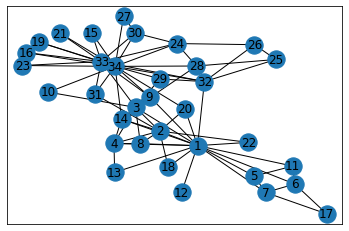

In [23]:
nx.draw_networkx(G)

## 1.2 Visualization of DeepWalk Embeddings

In [24]:
def plot_nodes(word_list):
    X = model.wv[word_list]
    
    # reduce dimensions to 2
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)
    
    
    plt.figure(figsize=(12,9))
    # create a scatter plot of the projection
    plt.scatter(result[:, 0], result[:, 1])
    for i, word in enumerate(word_list):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]))
        
    plt.show()

In [25]:
numbers = list(G.nodes)

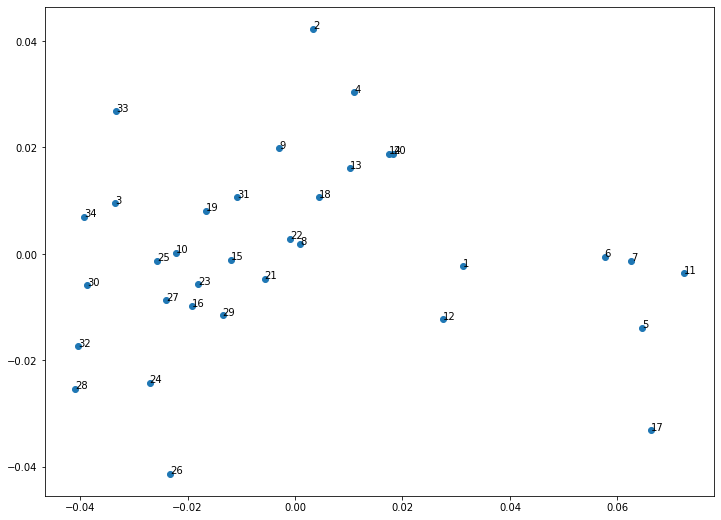

In [26]:
plot_nodes(numbers)

# 2. Node2Vec:

## Libraries needed

**We need following libraries: networkx, Node2Vec, TSNE, text-unidecode**

In [27]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from node2vec import Node2Vec


## Loading Dataset

In [28]:
# import the karate club csv file where edge list is stored (separated by space)
edge_list = pd.read_csv("../input/karate-edgelistcsv/karate_edgelist.csv", sep = ' ', header = None)

In [29]:
# check first five rows of the dataframe
edge_list.head()

,0,1
0,1,32
1,1,22
2,1,20
3,1,18
4,1,14


In [30]:
# rename columns of the dataframe
edge_list.rename(columns = {0:'source', 1: 'target'}, inplace = True)

In [31]:
# check shape of the dataframe
edge_list.shape

(78, 2)

In [32]:
# create undirected graph from the edgelist
G=nx.from_pandas_edgelist(edge_list, source='source', target='target', create_using=nx.Graph())

In [33]:
# check the basic properties of the graph
nx.info(G)

'Name: \nType: Graph\nNumber of nodes: 34\nNumber of edges: 77\nAverage degree:   4.5294'

In [34]:
# Get the names of the nodes
G.nodes

NodeView((1, 32, 22, 20, 18, 14, 13, 12, 11, 9, 8, 7, 6, 5, 4, 3, 2, 31, 10, 33, 29, 28, 17, 34, 15, 16, 19, 21, 23, 24, 30, 26, 25, 27))

# 2.1 Node2Vec Basics

In [35]:
# Precompute probabilities and generate walks - **ON WINDOWS ONLY WORKS WITH workers=1**
node2vec = Node2Vec(G, dimensions=128, walk_length=40, num_walks=100, workers=2)

Computing transition probabilities:   0%|          | 0/34 [00:00<?, ?it/s]

In [36]:
# Embed nodes
model = node2vec.fit(window=10, min_count=1)

## Retreive the dimension of a particular node

In [37]:
# Get the vector of node '1'
model.wv.get_vector('1')

array([ 0.02577361,  0.13097093,  0.10028297, -0.07990255, -0.05187919,
       -0.07496994, -0.05749423,  0.07268036,  0.1110784 , -0.02245005,
        0.15250291, -0.0280696 ,  0.08466129, -0.13887012, -0.0204826 ,
        0.00811203,  0.00379535,  0.08023734, -0.0069318 ,  0.06370034,
        0.00936789,  0.04306976,  0.12019809,  0.03519715, -0.19999692,
        0.21765067, -0.02843375, -0.02440749,  0.08535719,  0.06520139,
       -0.22438462,  0.03899153, -0.2533022 ,  0.08170288, -0.03117553,
        0.06621175,  0.10554881,  0.19609101,  0.17065156, -0.17557998,
       -0.03256113,  0.13863733, -0.02683056,  0.01062548,  0.13043758,
        0.0032211 ,  0.01717834, -0.0982134 , -0.11395664, -0.07772214,
        0.07469835, -0.16022192,  0.07564208,  0.09219234,  0.17602472,
       -0.021694  ,  0.11540637,  0.0508487 , -0.10319234, -0.22715981,
       -0.03257522, -0.03385786,  0.01842325, -0.07090285,  0.14760987,
       -0.05463113, -0.02169513, -0.02233699,  0.09070348, -0.19

## Most similar nodes to a particular node

In [38]:
# most similar nodes to node '1'
for node, _ in model.wv.most_similar('1'):
    print((node, _))

('11', 0.7820797562599182)
('7', 0.780707597732544)
('5', 0.7650891542434692)
('12', 0.7636690735816956)
('18', 0.7599439024925232)
('6', 0.7547723650932312)
('22', 0.6998350620269775)
('13', 0.6826866865158081)
('4', 0.6782787442207336)
('17', 0.6778348088264465)


## Verify the similar nodes using networkx graph

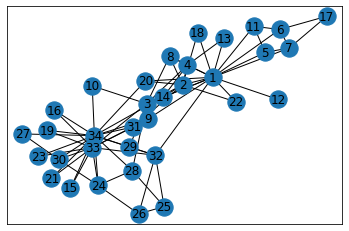

In [39]:
# verify the most similar nodes generated by node2vec from the graph
nx.draw_networkx(G)

## Save the embeddings and the trained model 

In [40]:
# save the node embeddings
model.wv.save_word2vec_format('embedding.csv')

In [41]:
# save the model for later use (useful when node2Vec takes lots of time/memory to generate node embeddings)
model.save('model')

## Retreive all the nodes' embeddings

In [42]:
# Retrieve node embeddings
node_ids = model.wv.index_to_key  # list of node IDs
node_embeddings = model.wv.vectors

In [43]:
print(node_ids)
print(node_embeddings)

['34', '1', '33', '3', '2', '32', '4', '24', '14', '7', '6', '30', '28', '8', '9', '5', '11', '20', '25', '29', '31', '26', '17', '27', '18', '23', '13', '21', '19', '16', '15', '10', '22', '12']
[[ 0.08442615 -0.0983702   0.08356661 ... -0.05818303 -0.02657141
   0.08350533]
 [ 0.02577361  0.13097093  0.10028297 ... -0.2258471  -0.09263913
  -0.03208111]
 [ 0.08589508 -0.07540712  0.0837869  ...  0.02771024 -0.07633106
   0.12416778]
 ...
 [ 0.03544052  0.08873448  0.16724466 ... -0.15484624 -0.13415
   0.1280353 ]
 [-0.02385182  0.04315604  0.0346602  ... -0.2847077   0.11066637
  -0.1327758 ]
 [-0.00141191  0.08087809  0.04774344 ... -0.14461626  0.07504072
   0.02060608]]


# 2.2 Use case: Node embeddings for Clustering
Embeddings can be used in various downstream tasks such as Classification, Link Prediction, etc.

### Reference: https://towardsdatascience.com/node2vec-embeddings-for-graph-data-32a866340fef
### TSNE link -https://www.youtube.com/watch?v=NEaUSP4YerM&t=144s&ab_channel=StatQuestwithJoshStarmer

In [44]:
!pip install text-unidecode
#!pip install tsne

In [45]:
import warnings
from text_unidecode import unidecode
from collections import deque
warnings.filterwarnings('ignore')
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches
import seaborn as sns

sns.set_style('whitegrid')

## Load data 

In [46]:
data = pd.read_csv('../input/fifa2017/FullData.csv', usecols=['Name', 'Club', 'Club_Position', 'Rating'])

## Pre-processing steps


In [47]:
# Lowercase columns for convenience
data.columns = list(map(str.lower, data.columns))

# Reformat strings: lowercase, ' ' -> '_' and é, ô etc. -> e, o
reformat_string = lambda x: unidecode(str.lower(x).replace(' ', '_'))
    
data['name'] = data['name'].apply(reformat_string)
data['club'] = data['club'].apply(reformat_string)

# Lowercase position
data['club_position'] = data['club_position'].str.lower()

# Ignore substitutes and reserves 
data = data[(data['club_position'] != 'sub') & (data['club_position'] != 'res')]

# Fix lcm rcm -> cm cm
fix_positions = {'rcm' : 'cm', 'lcm': 'cm', 'rcb': 'cb', 'lcb': 'cb', 'ldm': 'cdm', 'rdm': 'cdm'}
data['club_position'] = data['club_position'].apply(lambda x: fix_positions.get(x, x))

# For example sake we will keep only 7 clubs
clubs = {'real_madrid', 'manchester_utd', 
         'manchester_city', 'chelsea', 'juventus', 
         'fc_bayern', 'napoli'}

data = data[data['club'].isin(clubs)]


# Verify we have 11 player for each team
assert all(n_players == 11 for n_players in data.groupby('club')['name'].nunique())

data

,name,club,club_position,rating
0,cristiano_ronaldo,real_madrid,lw,94
4,manuel_neuer,fc_bayern,gk,92
5,de_gea,manchester_utd,gk,90
6,robert_lewandowski,fc_bayern,st,90
7,gareth_bale,real_madrid,rw,90
...,...,...,...,...
615,marcos_alonso,chelsea,lwb,79
687,gael_clichy,manchester_city,lb,79
850,victor_moses,chelsea,rwb,78
892,willy_caballero,manchester_city,gk,78


## Formations of the teams

In [48]:
FORMATIONS = {'4-3-3_4': {'gk': ['cb_1', 'cb_2'],                           # Real madrid
                          'lb': ['lw', 'cb_1', 'cm_1'],
                          'cb_1': ['lb', 'cb_2', 'gk'],
                          'cb_2': ['rb', 'cb_1', 'gk'],
                          'rb': ['rw', 'cb_2', 'cm_2'],
                          'cm_1': ['cam', 'lw', 'cb_1', 'lb'],
                          'cm_2': ['cam', 'rw', 'cb_2', 'rb'],
                          'cam': ['cm_1', 'cm_2', 'st'],
                          'lw': ['cm_1', 'lb', 'st'],
                          'rw': ['cm_2', 'rb', 'st'],
                          'st': ['cam', 'lw', 'rw']},
              '5-2-2-1': {'gk': ['cb_1', 'cb_2', 'cb_3'],                   # Chelsea
                          'cb_1': ['gk', 'cb_2', 'lwb'],
                          'cb_2': ['gk', 'cb_1', 'cb_3', 'cm_1', 'cb_2'],
                          'cb_3': ['gk', 'cb_2', 'rwb'],
                          'lwb': ['cb_1', 'cm_1', 'lw'],
                          'cm_1': ['lwb', 'cb_2', 'cm_2', 'lw', 'st'],
                          'cm_2': ['rwb', 'cb_2', 'cm_1', 'rw', 'st'],
                          'rwb': ['cb_3', 'cm_2', 'rw'],
                          'lw': ['lwb', 'cm_1', 'st'],
                          'st': ['lw', 'cm_1', 'cm_2', 'rw'],
                          'rw': ['st', 'rwb', 'cm_2']},
              '4-3-3_2': {'gk': ['cb_1', 'cb_2'],                           # Man UTD / CITY
                          'lb': ['cb_1', 'cm_1'],
                          'cb_1': ['lb', 'cb_2', 'gk', 'cdm'],
                          'cb_2': ['rb', 'cb_1', 'gk', 'cdm'],
                          'rb': ['cb_2', 'cm_2'],
                          'cm_1': ['cdm', 'lw', 'lb', 'st'],
                          'cm_2': ['cdm', 'rw', 'st', 'rb'],
                          'cdm': ['cm_1', 'cm_2', 'cb_1', 'cb_2'],
                          'lw': ['cm_1', 'st'],
                          'rw': ['cm_2', 'st'],
                          'st': ['cm_1', 'cm_2', 'lw', 'rw']},              # Juventus, Bayern
                            '4-2-3-1_2': {'gk': ['cb_1', 'cb_2'],
                            'lb': ['lm', 'cdm_1', 'cb_1'],
                            'cb_1': ['lb', 'cdm_1', 'gk', 'cb_2'],
                            'cb_2': ['rb', 'cdm_2', 'gk', 'cb_1'],
                            'rb': ['cb_2', 'rm', 'cdm_2'],
                            'lm': ['lb', 'cdm_1', 'st', 'cam'],
                            'rm': ['rb', 'cdm_2', 'st', 'cam'],
                            'cdm_1': ['lm', 'cb_1', 'rb', 'cam'],
                            'cdm_2': ['rm', 'cb_2', 'lb', 'cam'],
                            'cam': ['cdm_1', 'cdm_2', 'rm', 'lm', 'st'],
                            'st': ['lm', 'rm', 'cam']},
              '4-3-3': {'gk': ['cb_1', 'cb_2'],                             # Napoli
                        'lb': ['cb_1', 'cm_1'],
                        'cb_1': ['lb', 'cb_2', 'gk', 'cm_2'],
                        'cb_2': ['rb', 'cb_1', 'gk', 'cm_2'],
                        'rb': ['cb_2', 'cm_3'],
                        'cm_1': ['cm_2', 'lw', 'lb'],
                        'cm_3': ['cm_2', 'rw', 'rb'],
                        'cm_2': ['cm_1', 'cm_3', 'st', 'cb_1', 'cb_2'],
                        'lw': ['cm_1', 'st'],
                        'rw': ['cm_3', 'st'],
                        'st': ['cm_2', 'lw', 'rw']}}

## Creation of graph

In [49]:
add_club_suffix = lambda x, c: x + '_{}'.format(c)

graph = nx.Graph()
formatted_positions = set()

def club2graph(club_name, formation, graph):
    club_data = data[data['club'] == club_name]
    
    club_formation = FORMATIONS[formation]
    
    club_positions = dict()
    
    # Assign positions to players
    available_positions = deque(club_formation)
    available_players = set(zip(club_data['name'], club_data['club_position']))
    
    roster = dict()  # Here we will store the assigned players and positions
    
    while available_positions:
        position = available_positions.pop()
        name, pos = [(name, position) for name, p in available_players if position.startswith(p)][0]        
        
        roster[name] = pos
        
        available_players.remove((name, pos.split('_')[0]))
        
    reverse_roster = {v: k for k, v in roster.items()}
    # Build the graph
    for name, position in roster.items():
        # Connect to team name
        graph.add_edge(name, club_name)
        
        # Inter team connections
        for teammate_position in club_formation[position]:
            # Connect positions
            graph.add_edge(add_club_suffix(position, club_name),
                           add_club_suffix(teammate_position, club_name))
            
            # Connect player to teammate positions
            graph.add_edge(name,
                           add_club_suffix(teammate_position, club_name))
            
            # Connect player to teammates
            graph.add_edge(name, reverse_roster[teammate_position])
            
            # Save for later trimming
            formatted_positions.add(add_club_suffix(position, club_name))
            formatted_positions.add(add_club_suffix(teammate_position, club_name))
            
    return graph

### Teams Mapping

In [50]:
teams = [('real_madrid', '4-3-3_4'), 
         ('chelsea', '5-2-2-1'),
         ('manchester_utd', '4-3-3_2'),
         ('manchester_city', '4-3-3_2'),
         ('juventus', '4-2-3-1_2'),
         ('fc_bayern', '4-2-3-1_2'),
         ('napoli', '4-3-3')]

In [51]:
# create graph for a specific team
graph = club2graph('real_madrid', '4-3-3_4', graph)

In [52]:
# 7 graphs (each for team)
for team, formation in teams:
    graph = club2graph(team, formation, graph)

### Node2Vec

In [53]:
node2vec = Node2Vec(graph, dimensions=20, walk_length=16, num_walks=100, workers=2)

Computing transition probabilities:   0%|          | 0/161 [00:00<?, ?it/s]

## Most similar nodes

In [54]:
fix_formatted_positions = lambda x: x.split('_')[0] if x in formatted_positions else x
reformatted_walks = [list(map(fix_formatted_positions, walk)) for walk in node2vec.walks]
node2vec.walks = reformatted_walks
# Learn embeddings 
model = node2vec.fit(window=10, min_count=1)

In [55]:
for node, _ in model.wv.most_similar('real_madrid'):
    print(node)

luka_modric
toni_kroos
james_rodriguez
pepe
sergio_ramos
carvajal
gareth_bale
marcelo
cristiano_ronaldo
karim_benzema


In [56]:
for node, _ in model.wv.most_similar('paulo_dybala'):
    print(node)

gonzalo_higuain
juventus
mario_mandzukic
alex_sandro
juan_cuadrado
stephan_lichtsteiner
miralem_pjanic
sami_khedira
giorgio_chiellini
gianluigi_buffon


## Visualization of the teams

In [57]:
player_nodes = [x for x in model.wv.key_to_index if len(x) > 3 and x not in clubs]
embeddings = np.array([model.wv[x] for x in player_nodes])

In [58]:
tsne = TSNE(n_components=2, random_state=7, perplexity=15)
embeddings_2d = tsne.fit_transform(embeddings)

In [59]:
# Assign colors to players
team_colors = {
    'real_madrid': 'lightblue',
    'chelsea': 'b',
    'manchester_utd': 'r',
    'manchester_city': 'teal',
    'juventus': 'gainsboro',
    'napoli': 'deepskyblue',
    'fc_bayern': 'tomato' 
}

data['color'] = data['club'].apply(lambda x: team_colors[x])
player_colors = dict(zip(data['name'], data['color']))
colors = [player_colors[x] for x in player_nodes]

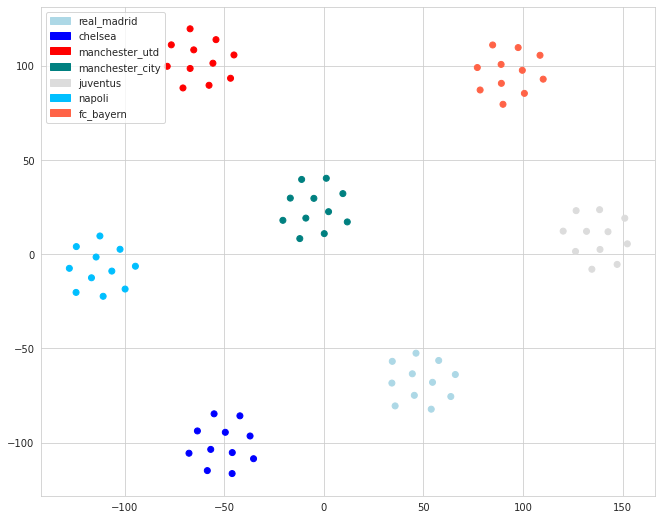

In [60]:
figure = plt.figure(figsize=(11, 9))

ax = figure.add_subplot(111)

ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors)

# Create team patches for legend
team_patches = [mpatches.Patch(color=color, label=team) for team, color in team_colors.items()]
ax.legend(handles=team_patches);